# Отклонение системой
Обучим модель на всех данных и покажем, точность для новых и поддержанных автомобилей.

In [2]:
import xgboost as xgb
from xgboost import Booster
import numpy as np
import matplotlib
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

df0: pd.DataFrame = pd.read_pickle('/mnt/hit4/hit4user/PycharmProjects/mysql_connector/final_features.pickle')

df = df0
X = df.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df['system']
print("X строк, столбцов", X.shape)
print("Y", Y.shape)
p = len(Y[Y == 1])
n = len(Y[Y == 0])
print("Y OK system:", p)
print("Y FAIL system:", n)
print("FAIL/OK system:", "%.2f" % (n / p))

Y = df['under']
p = len(Y[Y == 1])
n = len(Y[Y == 0])
print("Y OK under:", p)
print("Y FAIL under:", n)
print("FAIL/OK under:", "%.2f" % (n / p))
print("FAIL/OK under:", "%.2f" % (n / p))
print("Андерайтер положительных:", len(df0[df0['under'] == 1]))
print("NaN exist?", df0.isnull().values.any())
Y = df['system']

X строк, столбцов (12538, 10233)
Y (12538,)
Y OK system: 5430
Y FAIL system: 7108
FAIL/OK system: 1.31
Y OK under: 444
Y FAIL under: 3061
FAIL/OK under: 6.89
FAIL/OK under: 6.89
Андерайтер положительных: 444
NaN exist? True


In [5]:
dtrain = xgb.DMatrix(X, Y)
param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 1.6, 'max_depth': 3, 'eta': 0.1,
         'gamma': 1}
num_round = 9
res = xgb.cv(param, dtrain, num_round, metrics=['error', 'auc'], nfold=5)
print("cross-train accuracy train\t", 1 - np.mean(res['train-error-mean']))
print("cross-train gini\t", np.mean(res['train-auc-mean'] * 2 - 1))
print("cross-test accuracy test\t", 1 - np.mean(res['test-error-mean']))
print("cross-test gini\t\t", np.mean(res['test-auc-mean'] * 2 - 1))

cross-train accuracy train	 0.8571121333333334
cross-train gini	 0.8502689777777778
cross-test accuracy test	 0.8548776666666666
cross-test gini		 0.8485516444444444


# Кросс-валидация с ручным подбором параметров. На всех данных. Для отклонения системой.

In [6]:
dtrain = xgb.DMatrix(X, Y)
param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'max_depth': 3, 'eta': 0.3,
         'gamma': 1}
num_round = 2
res = xgb.cv(param, dtrain, num_round, metrics=['error', 'auc'], nfold=5)
print("cross-train accuracy train", 1 - np.mean(res['train-error-mean']))
print("cross-train gini", np.mean(res['train-auc-mean'] * 2 - 1))
print("cross-test accuracy test", 1 - np.mean(res['test-error-mean']))
print("cross-test gini", np.mean(res['test-auc-mean'] * 2 - 1))

cross-train accuracy train 0.8579021
cross-train gini 0.8429803999999999
cross-test accuracy test 0.8555183
cross-test gini 0.8408134000000003


### Так как точность для train и для test отличаются на 0.003, 
заключам что для этих параметров модель не переобучается.

Обучаем модель на всей выборке, что на 1/5 больше предыдушего этапа, 
поэтому уменьшаем eta, чтобы исключить переобучение.

In [60]:
param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'max_depth': 3, 'eta': 0.3,
         'gamma': 1}
num_round = 2
num_round = 6
bst: Booster = xgb.train(param, dtrain, num_round)
# test
res: np.array = bst.predict(dtrain)
    
def result(y, truth):
    print("accuracy\t%f" % (np.round(y) == truth).mean())
    auc = sklearn.metrics.roc_auc_score(truth, y)
    print("auc", auc)
    gini = 2 * auc - 1
    print("gini", gini)
    rep = sklearn.metrics.classification_report(truth, np.round(y))
    print(rep)
    
result(res, Y)

accuracy	0.886815
auc 0.9115784067564483
gini 0.8231568135128966
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1685
           1       0.88      0.75      0.81       780

    accuracy                           0.89      2465
   macro avg       0.88      0.85      0.86      2465
weighted avg       0.89      0.89      0.88      2465



Теперь протестируем модель на подвыборках для новых и поддержанных автомобилях

In [61]:
print("TEST new")
df = df0[df0['`condition`_new'] == 1]
X = df.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df['system']
dtest = xgb.DMatrix(X, Y)  # , feature_names=f_names[1:])
ypred2: np.array = bst.predict(dtest)
result(ypred2, Y)

print("TEST uses")
df = df0[df0['`condition`_uses'] == 1]
X = df.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df['system']
dtest = xgb.DMatrix(X, Y)  # , feature_names=f_names[1:])
ypred2: np.array = bst.predict(dtest)
result(ypred2, Y)

TEST new
accuracy	0.838292
auc 0.8731036259758578
gini 0.7462072519517156
              precision    recall  f1-score   support

           0       0.82      0.93      0.87      5158
           1       0.87      0.70      0.78      3413

    accuracy                           0.84      8571
   macro avg       0.85      0.81      0.82      8571
weighted avg       0.84      0.84      0.83      8571

TEST uses
accuracy	0.886815
auc 0.9115784067564483
gini 0.8231568135128966
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1685
           1       0.88      0.75      0.81       780

    accuracy                           0.89      2465
   macro avg       0.88      0.85      0.86      2465
weighted avg       0.89      0.89      0.88      2465



# Модель обученная только на новых автомабилях.

In [63]:
df = df0[df0['`condition`_new'] == 1].copy()
X = df.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df['system']
print("X строк, столбцов", X.shape)
dtrain = xgb.DMatrix(X, Y)
res = xgb.cv(param, dtrain, num_round, metrics=['error', 'auc'], nfold=5)
print("cross-train accuracy train", 1 - np.mean(res['train-error-mean']))
print("cross-train gini", np.mean(res['train-auc-mean'] * 2 - 1))
print("cross-test accuracy test", 1 - np.mean(res['test-error-mean']))
print("cross-test gini", np.mean(res['test-auc-mean'] * 2 - 1))
bst: Booster = xgb.train(param, dtrain, num_round)

X строк, столбцов (8571, 210)
cross-train accuracy train 0.8437545714285715
cross-train gini 0.7636499428571429
cross-test accuracy test 0.8390407714285715
cross-test gini 0.7577827428571429


In [64]:
print("TEST new")
df = df0[df0['`condition`_new'] == 1]
X = df.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df['system']
dtest = xgb.DMatrix(X, Y)
ypred2: np.array = bst.predict(dtest)
result(ypred2, Y)

print("TEST uses")
df = df0[df0['`condition`_uses'] == 1]
X = df.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df['system']
dtest = xgb.DMatrix(X, Y)
ypred2: np.array = bst.predict(dtest)
result(ypred2, Y)

TEST new
accuracy	0.842959
auc 0.8881364981441418
gini 0.7762729962882835
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      5158
           1       0.88      0.70      0.78      3413

    accuracy                           0.84      8571
   macro avg       0.85      0.82      0.83      8571
weighted avg       0.85      0.84      0.84      8571

TEST uses
accuracy	0.876268
auc 0.8928703492353344
gini 0.7857406984706687
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1685
           1       0.82      0.77      0.80       780

    accuracy                           0.88      2465
   macro avg       0.86      0.85      0.85      2465
weighted avg       0.87      0.88      0.88      2465



Как видим, точность модели, обученной на новых автомобилях, для поддержанных автомобилей отличается на 0.03 от точности модели обученной на всех данных.
Поэтому применять отдельные модели для новых и поддержанных не целесообразно.

# Анализ возможностей модели 

In [8]:
from sklearn.model_selection import train_test_split
X = df0.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df0['system']
cp = {'c5': 0,
      'c7': 0,
      'c8': 0,
      'c9': 0,
      'c95': 0
     }
def an(param, num_round):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)
    dtrain = xgb.DMatrix(X_train, Y_train)
    dtest = xgb.DMatrix(X_test, Y_test)
    bst: Booster = xgb.train(param, dtrain, num_round)
    ypred2: np.array = bst.predict(dtest)
    
    for i, x in enumerate(ypred2):
        if np.round(x) == Y[i] and Y[i] == 0:
#             v = (0.5 - x) / 0.5
            v = 1 - x
            if v > 0.5:
                cp['c5'] += 1
            if v > 0.7:
                cp['c7'] += 1
            if v > 0.8:
                cp['c8'] += 1
            if v > 0.9:
                cp['c9'] += 1
            if v > 0.95:
                cp['c95'] += 1
    [print(x, "%.2f%%" % ((cp[x]/n)*100)) for x in cp.keys()]
    print('')
param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'max_depth': 4, 'eta': 0.2,
         'gamma': 0}
an(param, num_round = 6)
print("%.2f%%" % (((cp['c8']/n) * 0.84)* 100), 'процентов отклонений заявки верны с вероятностью 80%')

c5 51.00%
c7 39.53%
c8 21.33%
c9 0.00%
c95 0.00%

17.92% процентов отклонений заявки верны с вероятностью 80%


2% отколений верны с вероятностью больше 80%, из них не ошибочны 84%, то есть 0.02*0.84=0.01, 
1% отколений верны с вероятностью больше 80%
# Подберем параметры так, чтобы увеличить точность для отклонений заявки.

In [ ]:
param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 1.8, 'max_depth': 17, 'eta': 1,
         'gamma': 0}
num_round = 6
dtrain = xgb.DMatrix(X, Y)
res = xgb.cv(param, dtrain, num_round, metrics=['error', 'auc'], nfold=5)
print("cross-train accuracy train", 1 - np.mean(res['train-error-mean']))
print("cross-train gini", np.mean(res['train-auc-mean'] * 2 - 1))
acc_test = 1 - np.mean(res['test-error-mean'])
print("cross-test accuracy test", acc_test)
print("cross-test gini", np.mean(res['test-auc-mean'] * 2 - 1))

cp = {'c5': 0,
      'c7': 0,
      'c8': 0,
      'c9': 0,
      'c95': 0
     }
an(param, num_round)
print("%.2f%%" % (((cp['c7']/n) * acc_test)* 100), 'процентов предсказанных отклонений заявки верны с вероятностью 70%')
print("%.2f%%" % (((cp['c8']/n) * acc_test)* 100), 'процентов предсказанных отклонений заявки верны с вероятностью 80%')
print("%.2f%%" % (((cp['c9']/n) * acc_test)* 100), 'процентов предсказанных отклонений заявки верны с вероятностью 90%')
print("%.2f%%" % (((cp['c95']/n) * acc_test)* 100), 'процентов предсказанных отклонений заявки верны с вероятностью 95%')

## Итог: Рузультаты неудовлетворительные
# Обучив модель на одобренных андерайтером и протестируем на отклоненных системой.

In [7]:
from sklearn.model_selection import KFold, StratifiedShuffleSplit

X = df0.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df0[['system', 'under']]

param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 45, 'max_depth': 3, 'eta': 0.1,
         'gamma': 1}
num_round = 4
# Кросс-валидация для отслеживания переобучения
dtrain = xgb.DMatrix(X, Y['under'])
res = xgb.cv(param, dtrain, num_round, metrics=['error', 'auc'], nfold=5)
print("cross-train accuracy train", 1 - np.mean(res['train-error-mean']))
print("cross-train gini", np.mean(res['train-auc-mean'] * 2 - 1))
print("cross-test accuracy test", 1 - np.mean(res['test-error-mean']))
print("cross-test gini", np.mean(res['test-auc-mean'] * 2 - 1))
print('')
# Кросс-валидация для уменьшения FalseNegative
res1 = []
res2 = []
res3 = []
res4 = []
acc1 = []
gini1 = []

res21 = []
res22 = []
res23 = []
res24 = []

acc2 = []
gini2 = []
def run():
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        Y_train, Y_test = Y.iloc[train_index, :], Y.iloc[test_index, :]

        # Обучаем на фолде отклоненных андерайтером
        dtrain = xgb.DMatrix(X_train, Y_train['under']) # under
        bst: Booster = xgb.train(param, dtrain, num_round)

        # Тестируем на отклоненных системой
        dtest = xgb.DMatrix(X_test, Y_test['system']) # system
        ypred2: np.array = bst.predict(dtest)

        cn = []
        cp = []
        for i, x in enumerate(Y_test['system']):
            if x == 0:
                cn.append(ypred2[i])
            if x == 1:
                cp.append(ypred2[i])
        res21.append((np.round(cn) == 0).mean())
        res22.append((np.round(cn) == 1).mean())
        res23.append((np.round(cp) == 1).mean())
        res24.append((np.round(cp) == 0).mean())
        acc1.append((np.round(ypred2) == Y_test['system']).mean())
        auc = sklearn.metrics.roc_auc_score(Y_test['system'], ypred2)
        gini1.append(2 * auc - 1)


        # тестируем на отклоненных андерайтором
        dtest = xgb.DMatrix(X_test, Y_test['under'])
        ypred2: np.array = bst.predict(dtest)

        cn = []
        cp = []
        for i, x in enumerate(Y_test['under']):
            if x == 0:
                cn.append(ypred2[i])
            if x == 1:
                cp.append(ypred2[i])
        res1.append((np.round(cn) == 0).mean())
        res2.append((np.round(cn) == 1).mean())
        res3.append((np.round(cp) == 1).mean())
        res4.append((np.round(cp) == 0).mean())
        acc2.append((np.round(ypred2) == Y_test['under']).mean())
        auc = sklearn.metrics.roc_auc_score(Y_test['under'], ypred2)
        gini2.append(2 * auc - 1)

    print("Результаты кросс-валидации тестирования на отклоненных системой")
    print("Точность:", np.array(acc1).mean())
    print("Коэффициент gini:", np.array(gini1).mean())
    print("TrueNegative/Negative для 0:\t%f" % np.array(res21).mean())
    print("FalsePositive/Negative для 0:\t%f" % np.array(res22).mean())
    print("TruePositive/Positive для 1:\t%f" % np.array(res23).mean())
    print("FalseNegative/Positive для 1:\t%f" % np.array(res24).mean(), "\n")

    print("Результаты кросс-валидации тестирования на отклоненных андерайтором")
    print("Точность:", np.array(acc2).mean())
    print("Коэффициент gini:", np.array(gini2).mean())
    print("TrueNegative/Negative для 0:\t%f" % np.array(res1).mean())
    print("FalsePositive/Negative для 0:\t%f" % np.array(res2).mean())
    print("TruePositive/Positive для 1:\t%f" % np.array(res3).mean())
    print("* FalseNegative/Positive для 1:\t%f" % np.array(res4).mean())

print("KFold\n")
skf = KFold(n_splits=5)
run()
print("\nStratifiedShuffleSplit\n")
skf = StratifiedShuffleSplit(n_splits=5)
run()

XGBoostError: [18:22:03] /workspace/src/objective/regression_obj.cu:102: label must be in [0,1] for logistic regression
Stack trace:
  [bt] (0) /home/u2/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x54) [0x7fb61b440614]
  [bt] (1) /home/u2/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x4cc) [0x7fb61b6eda1c]
  [bt] (2) /home/u2/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x376) [0x7fb61b52c9a6]
  [bt] (3) /home/u2/.local/lib/python3.7/site-packages/xgboost/./lib/libxgboost.so(XGBoosterUpdateOneIter+0x29) [0x7fb61b42f639]
  [bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call_unix64+0x4c) [0x7fb66578281e]
  [bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.6(ffi_call+0x22f) [0x7fb6657821ef]
  [bt] (6) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x581) [0x7fb664539581]
  [bt] (7) /usr/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x12aac) [0x7fb664539aac]
  [bt] (8) /usr/bin/python3(_PyObject_FastCallKeywords+0x4e3) [0x5c9f63]



# Нам удалось обучить  модель определяющую отклонение системой заявки. Вероятность отвергнуть хорошую заявку ~ 1%.

# Проанализируем корреляцию андерайтера с анкетным скорингом.

Коэффициент корреляции между Анкетным Скорингом и Андерайтором: -0.012431190608889548


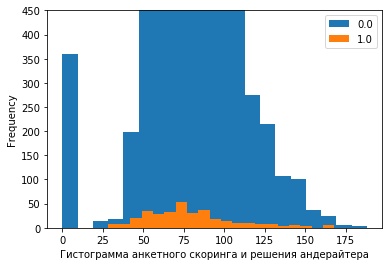

In [75]:
from scipy.stats import pearsonr
a = pearsonr(df0['anket_score'], df0['under'])
print("Коэффициент корреляции между Анкетным Скорингом и Андерайтором:", a[0])

df0.groupby('under')['anket_score'].plot.hist(bins=20, ylim=(0,450))
plt.legend()
plt.xticks()
plt.xlabel('Гистограмма анкетного скоринга и решения андерайтера')
plt.show()

# Исследуем как влияет анкетный скоринг на нашу модель.

In [1]:
# dtrain = xgb.DMatrix(X, Y['system'])
# param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 1.7, 'max_depth': 17, 'eta': 0.5,
#              'gamma': 0}
# num_round = 6
# bst: Booster = xgb.train(param, dtrain, num_round)
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import StratifiedKFold

importance_sum = np.zeros(X.shape[1], dtype=np.float)
for i in range(100):
    depth = int((870 - 500) / 500 * 9)  # 6 - 15 # perfect 5
    n_est = int((950 - i) / 500 * 32) # 28-60 # perfect 50
    model = RandomForestClassifier(random_state=i, max_depth=depth, 
                                   n_estimators=n_est, max_leaf_nodes=17, 
                                   min_samples_split=2)
    model.fit(X, Y['system'])
    # TEST
    y_pred = model.predict(X)

    # FEATURE IMPORTANCE
    importances = model.feature_importances_  # feature importance
    importance_sum += importances

indices = np.argsort(importance_sum)[::-1]  # sort indexes

# Print the feature ranking
print("Feature ranking:")
print(importance_sum.shape)

for f in range(X.shape[1])[:10]: # первые 10
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importance_sum[indices[f]] / 100))

NameError: name 'X' is not defined

# Зависимость вероятности одобрения заявки обученной моделью от скоринга.
Используется усреднение на скользящем окне 5 ближайших значениях.

        anket_score           ver
count  11036.000000  11036.000000
mean      80.117978      0.364563
std       25.430379      0.093334
min        0.000000      0.330146
25%       65.000000      0.330146
50%       80.000000      0.330146
75%       94.000000      0.330146
max      188.000000      0.668961


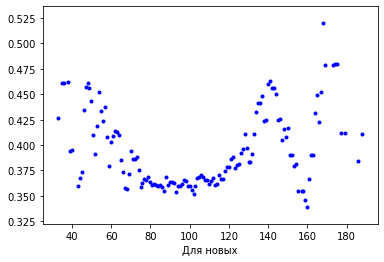

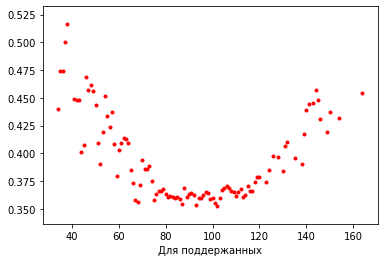

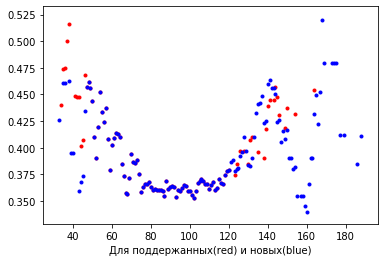

In [8]:
X = df0.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df0[['system', 'under']]

param = {'booster': 'gbtree', 'objective': 'binary:logistic', 'scale_pos_weight': 45, 'max_depth': 3, 'eta': 0.1,
         'gamma': 1}
num_round = 4

# создадим модель
dtrain = xgb.DMatrix(X, Y['under'])
bst: Booster = xgb.train(param, dtrain, num_round)
ypred: np.array = bst.predict(dtrain)

scor_ver = pandas.concat([X['anket_score'], pandas.Series(ypred, name='ver')], axis=1)
print(scor_ver.describe())

# вероятности одобрения андерайтором 
# для Для поддержанных автомобилей
X_uses = X[X['`condition`_uses'] == 1]
dtrain = xgb.DMatrix(X_uses, Y['under'])
ypred2: np.array = bst.predict(dtrain)
scor1 = list(sorted(set(X_uses['anket_score'].values)))
mean_ver1 = []
for x in scor1:
    mean = np.mean(scor_ver[scor_ver['anket_score'] == x]['ver'].values)
    mean_ver1.append(mean)
                    
# Для новых автомобилей
X_new = X[X['`condition`_new']==1]
dtrain = xgb.DMatrix(X_new, Y['under'])
ypred2: np.array = bst.predict(dtrain)
scor2 = list(sorted(set(X_new['anket_score'].values)))
mean_ver2 = []
for x in scor2:
    mean = np.mean(scor_ver[scor_ver['anket_score'] == x]['ver'].values)
    mean_ver2.append(mean)

mean_ver2 = pandas.Series(mean_ver2).rolling(window=5).mean()
plt.scatter(scor2, mean_ver2, color='blue', marker='.')
plt.xlabel('Для новых')
plt.show()

mean_ver1 = pandas.Series(mean_ver1).rolling(window=5).mean()
plt.scatter(scor1, mean_ver1, color='red', marker='.')
plt.xlabel('Для поддержанных')
plt.show()

plt.scatter(scor1, mean_ver1, color='red', marker='.')
plt.scatter(scor2, mean_ver2, color='blue', marker='.')
plt.xlabel('Для поддержанных(red) и новых(blue)')
plt.show()

Вероятность принятия решения должна рости с увеличением скоринга. Однако мы видим что она падает до 80-100, после начинает повышаться

# PDP Влияние анкетного скоринга на решение модели

## Поддержанных автомобилей

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from xgboost import XGBClassifier

X = df0.drop(['system'], 1)
X = X.drop(['under'], 1)
Y = df0[['system', 'under']]

# print(X.columns.values)
# exit(0)
# train model
model = XGBClassifier(booster='gbtree', objective='binary:logistic', scale_pos_weight=45, max_depth=3,
                      learning_rate=0.1, gamma=1, num_round=4)
est = model.fit(X, Y['under'])

# a = partial_dependence(est, features=[0], X=X, percentiles=(0, 1), grid_resolution=2)
# print(a)
X_uses = X[X['`condition`_uses'] == 1]
_ = plot_partial_dependence(est, X_uses, features=['anket_score'], n_jobs=4, grid_resolution=20) 


## Новых автомобилей

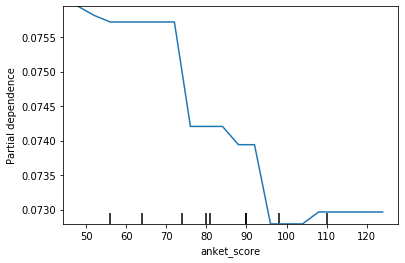

In [9]:
X_new = X[X['`condition`_new']==1]
_ = plot_partial_dependence(est, X_new, features=['anket_score'], n_jobs=4, grid_resolution=20) 